# Example analysis

This is a small walkthough of how I would imagine the database to be used. This is a very limited analysis, but is intended to show some of the visuals that can be created with this data set. I hope that if people continue to use and develop the code that there will be some highly accurate models created.

## Import Requirements 

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import operator
from collections import OrderedDict
from sklearn import preprocessing
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import string

Read in the data set and remove the rows that you do not want, in this case it is any player who was paid in a season but did not play. We used exact index locations

In [3]:
finalDF = pd.read_csv("final.csv")
finalDF.drop([135,157,158,315,388,519,545], axis=0, inplace=True)
print(finalDF)

     index      playerName  SEASON    salary   AGE    MP   FG   FGA    FG%  \
0      235   stephen curry    2009   2710560  21.0  36.2  6.6  14.3  0.462   
1      220   stephen curry    2010   2913840  22.0  33.6  6.8  14.2   0.48   
2      203   stephen curry    2011   3117120  23.0  28.2  5.6  11.4   0.49   
3      179   stephen curry    2012   3958742  24.0  38.2  8.0  17.8  0.451   
4       61   stephen curry    2013   9887642  25.0  36.5  8.4  17.7  0.471   
..     ...             ...     ...       ...   ...   ...  ...   ...    ...   
569    282      joe ingles    2015   2100000  28.0  15.3  1.5   3.6  0.426   
570    311      joe ingles    2016   2100000  29.0  24.0  2.5   5.5  0.452   
571     86      joe ingles    2017  13636364  30.0  31.4  4.1   8.8  0.467   
572    406  justin holiday    2016   1015696  27.0  20.0  2.8   6.6  0.433   
573    217  justin holiday    2017   4500000  28.0  31.5  4.0  10.9  0.371   

      3P  ...    FT%  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   

Example of a subset datafrae that can be made to analyze specific comparisons between feature variables. In this case we are looking at age vs average salary

In [4]:
salaryByAge = pd.DataFrame(columns=['Age', 'AvgSalary'])
for age in range(19,34):
    ageGroup = finalDF[finalDF['AGE'] == age]
    avgSalary = ageGroup['salary'].mean()
    salaryByAge.loc[len(salaryByAge.index)] = [age, avgSalary] 
print(salaryByAge)

     Age     AvgSalary
0   19.0  3.333490e+06
1   20.0  2.883343e+06
2   21.0  2.914777e+06
3   22.0  3.088231e+06
4   23.0  5.100101e+06
5   24.0  8.742167e+06
6   25.0  1.066020e+07
7   26.0  1.083170e+07
8   27.0  1.362803e+07
9   28.0  1.538563e+07
10  29.0  1.617419e+07
11  30.0  1.897431e+07
12  31.0  2.561936e+07
13  32.0  2.761620e+07
14  33.0  3.328571e+07


## Visualizations

Continuing on with age vs avarage salary, we can make a bar graph to help visualize this. Since we are only looking at the 200 highest paid players it makes sense that it would increase with age. If you are an older player but still made the list, it is beacuse you are highly valuable to your team. This would not be the case for an older player who doesnt get minutes. 

Text(0.5, 0, 'Age')

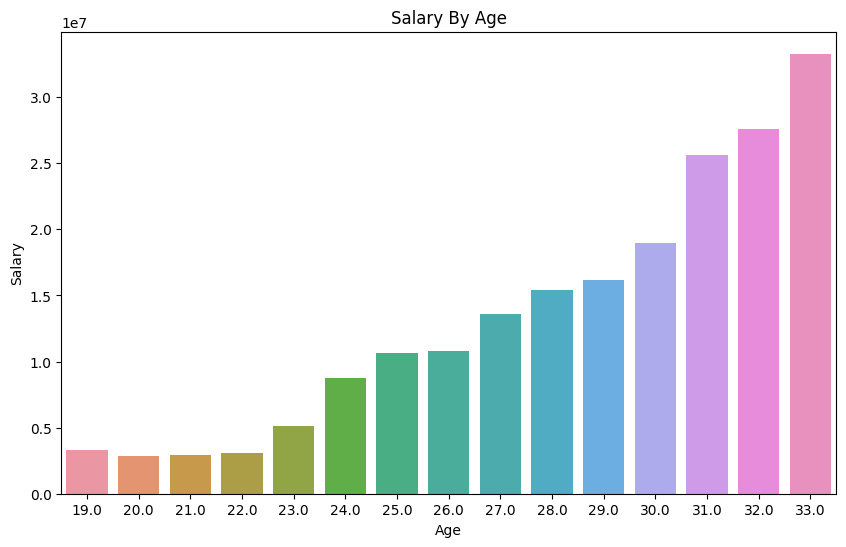

In [5]:
plt.figure(figsize=(10,6))
plt.title("Salary By Age")

sns.barplot(x=finalDF['AGE'], y=finalDF['salary'], errorbar=None)

plt.ylabel("Salary")
plt.xlabel("Age")

This is another graph of age vs salary but this time we can see all of the individual data points and their spread. From this we can see that the big jump in salary comes at age 23. This makes sense due to the fact that most players enter the league at 19 or 20 and take a few years to develop.

Text(0.5, 28.999999999999986, 'Age')

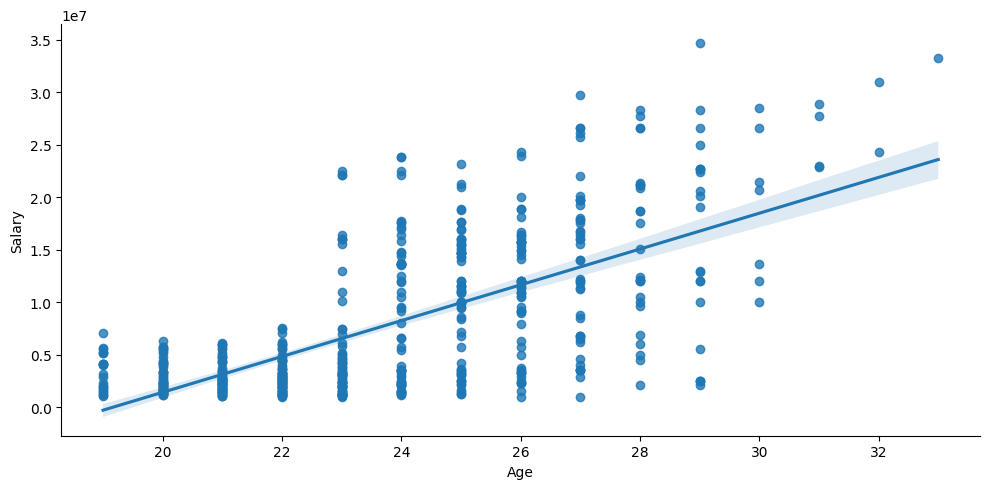

In [7]:
sns.lmplot(x="AGE", y="salary", data=finalDF,aspect=2)

plt.ylabel("Salary")
plt.xlabel("Age")

## Modeling

Here we are simply preparing the data for the model. We remove unneccesary columns, and split the data into training and testing sets.

In [8]:
contractsClean = finalDF.drop(columns=["playerName", 'SEASON', 'index', 'AGE'])
contractsClean = contractsClean.astype(float)
contractsClean = contractsClean.dropna()
X_full = contractsClean[:139]
X_test_full = contractsClean[140:]

y = X_full.salary
X = X_full.drop(columns=["salary"])

y_test = X_test_full.salary
X_test = X_test_full.drop(columns=["salary"])

X = X.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1,
                                                      random_state=0)

We created a model using random forest regression as a base model test. This is definetly not the best model but an example of one that can be created. We find that the MAE is 4045461, which is quite high but there is quite a bit of variance in the amount players are paid, and sometimes playes get away with being paid too much.

In [9]:
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
contracts_preds = model.predict(X_valid)
print(f"Validation MAE for Random Forest Model: {mean_absolute_error(y_valid, contracts_preds)}")

Validation MAE for Random Forest Model: 4045461.7414285704


This looks at deature importance to determine what is most impactful on salary according to the model. The biggest impact on player salary have points, FG made, and assists. The least important are offensive rebound, blocks, and free throws attempted.

In [10]:
importance = model.feature_importances_
columns_names = list(X.columns)
importance_sorted_list = sorted(zip(importance ,columns_names), reverse=True)
for v in (importance_sorted_list):
    print(f"{v[1]} - Score: {round(v[0], 3)}")

PTS - Score: 0.214
FG - Score: 0.191
AST - Score: 0.058
FT% - Score: 0.054
DRB - Score: 0.043
3PA - Score: 0.041
PF - Score: 0.038
MP - Score: 0.036
2P% - Score: 0.035
FGA - Score: 0.034
2P - Score: 0.033
TRB - Score: 0.026
TOV - Score: 0.024
STL - Score: 0.022
3P% - Score: 0.022
eFG% - Score: 0.022
FG% - Score: 0.019
2PA - Score: 0.018
3P - Score: 0.017
FT - Score: 0.015
FTA - Score: 0.014
BLK - Score: 0.013
ORB - Score: 0.011


Testing the model and looking at the difference inbetween our predicted and actual salaries.

In [13]:
y_pred = model.predict(X_test)

playerNames = finalDF['playerName'].to_list()
test_data_with_all_columns = finalDF
test_data_with_all_columns = test_data_with_all_columns.loc[:, test_data_with_all_columns.columns != 'playerName'].apply(pd.to_numeric)
test_data_with_all_columns.insert(1, 'playerName', playerNames, True)
test_data_with_all_columns = test_data_with_all_columns.dropna()

test_data_with_all_columns = test_data_with_all_columns[140:]

results = test_data_with_all_columns.loc[:, test_data_with_all_columns.columns.intersection(['playerName', 'salary', 'SEASON'])]
results['PREDICTED_SALARY'] = y_pred.astype(int)
results = results.rename(columns={'salary': 'ACTUAL_SALARY'})
results["DIFFRENCE"] = results['PREDICTED_SALARY'] - results["ACTUAL_SALARY"]
results.sort_values(by="DIFFRENCE", ascending = False)

,playerName,SEASON,ACTUAL_SALARY,PREDICTED_SALARY,DIFFRENCE
168,cj mccollum,2016,3219579,15927055,12707476
144,devin booker,2017,2319360,14840140,12520780
294,eric gordon,2010,3016680,11843006,8826326
386,derrick rose,2010,5546160,14248391,8702231
176,james harden,2012,5820416,14204171,8383755
...,...,...,...,...,...
345,steven adams,2017,22471911,4851565,-17620346
243,al horford,2017,27734405,8874113,-18860292
259,mike conley,2016,26540100,6388853,-20151247
225,kyle lowry,2017,28903704,8353254,-20550450


Bad pipe message: %s [b'\xdb\x96\x007yp\x14\xaf\x15\x11m0H(\xb3\x13\x95\xab qS\x9e\xd7C\x1b\xa7\xa7\xb35\xca[\x80\x1e\xf5\x93e0\x86\xbd\xa9\x8c\xdc\xa4\x19\x99\xf97\x19\x05\xf3u\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 P\xe9\x90\xaaD\x00\xdb\xbe`!\xf8\x80\x10\xb4\xeb\x01\x96\x1bQ\xf1c\xa2']
Bad pipe message: %s [b'\xb9\x10\xa0\xfc:.N[\xa6d\x9f3\x14\xa3\xe5\x9d\xa9w \x95xl]']
Bad pipe message: %s [b'6&\xe5\xbeX\xa4\xeb\x01;\xd6\x93>\x9c\x1f\x8b"\xbd\x87\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\x

## Conclusion

According to the model the model the best contracts from test data were signed CJ McCollum in 2016 and Devin Booker in 2017, both underpaid by almost 12 million. The most overpaid players were Kyle Lowry in 2017 (probably because he was intended to lead his team all the way to the championship) and Mike Conley in 2017, both being overpaid by more than 20 million according to the model.

I am aware of a lot of improvements that can me done to increase quality of the model, and I hope that one day I revisit and make a better one.